In [1]:
import os
import re
import pickle
import numpy as np
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

# Create Pickle - Original Images

In [3]:
def read_joints():
    """
     Read the joint labels from the text files.
   """
    joint_dict = {}
    path="dataset/projections_2d/"
    for i in range(1,3):
        data_dir = path+"data_"+str(i)+"/"
        with os.scandir(data_dir) as entries:
            for entry in entries:
                with open(os.path.join(data_dir,entry.name), "r") as f:
                    joints = np.zeros((0, 2))
                    for line in f:
                        _, x, y = line.split()
                        joint_coordinate = np.array([[float(x), float(y)]])
                        joints = np.vstack((joints, joint_coordinate))
                        key_part1="d_"+str(i)+"_"
                        key_part2="".join(re.findall("[0-9]+[_]*", entry.name))
                        joint_dict[key_part1+key_part2] = joints
    return joint_dict

In [4]:
def read_boundings():
    """
    Read bounding box labels from the text files.
    """
    bbox_dict = {}
    path="dataset/bounding_boxes/"
    
    for i in range(1,3):
        data_dir = path+"data_"+str(i)+"/"
        with os.scandir(data_dir) as entries:
            for entry in entries:
                with open(os.path.join(data_dir,entry.name), "r") as f:
                    key_part1="d_"+str(i)+"_"
                    key_part2="".join(re.findall("[0-9]+[_]*", entry.name))
                    key=key_part1+key_part2
                    bbox_dict[key] = {}
                    for line in f:
                        d_key, d_value = line.split()
                        bbox_dict[key][d_key] = np.array([[int(d_value)]])
    return bbox_dict


In [5]:
def read_images():
    """
    Read the image data from .jpg files
    """
    image_dict = {}
    path="dataset/annotated_frames/"
    
    for i in range(1,3):
        data_dir = path+"data_"+str(i)+"/"
        with os.scandir(data_dir) as entries:
            for entry in entries:
                with open(os.path.join(data_dir,entry.name), "r"):
                    if entry.name.endswith(".jpg"):
                        key_part1="d_"+str(i)+"_"
                        key_part2="".join(re.findall("[0-9]+[_]*", entry.name))
                        img=Image.open(os.path.join(data_dir,entry.name))
                        image_dict[key_part1+key_part2] = img.copy()
                        img.close() 
    return image_dict

In [6]:
def create_pickle():
    """
    Create a pickled from dictionary (data_hand_pose_original.pickle)
    """
    my_dict = {"images": read_images(),
             "joints": read_joints(),
             "bounding": read_boundings()}
    with open("data_hand_pose_original.pickle", "wb") as dataset:
        pickle.dump(my_dict, dataset)

In [7]:
create_pickle()

# Create Pickle - Cropped & Scaled Images

In [2]:
# Read the data
dataset = {}
with open("data_hand_pose_original.pickle", "rb") as f:
    dataset = pickle.load(f, encoding="bytes")

In [3]:
def crop_images():
    """
      Crop each hand image by looking at its bounding box labels.
      Also, keep the max height and max width of the cropped images to resize the images.

      https://pillow.readthedocs.io/en/3.0.x/reference/ImageOps.html#PIL.ImageOps.crop
      """
    max_w = 0
    max_h = 0
    cropped_dict = {}
    for name, image in dataset["images"].items():
        box=(dataset["bounding"][name]["LEFT"][0][0],
             dataset["bounding"][name]["TOP"][0][0],
             dataset["bounding"][name]["RIGHT"][0][0],
             dataset["bounding"][name]["BOTTOM"][0][0])
        cropped_dict[name] = image.crop(box)
        if cropped_dict[name].width > max_w:
            max_w = cropped_dict[name].width
        if cropped_dict[name].height > max_h:
            max_h = cropped_dict[name].height

    return cropped_dict, max_w, max_h

In [4]:
def pad_all_matrices(cropped_images,max_w,max_h):
    """
    Pad all the matrices to the: maximum height and maximum width in the cropped images
    
    https://pillow.readthedocs.io/en/3.0.x/reference/ImageOps.html#PIL.ImageOps.expand
    """
    padded_images ={}
    for name, _ in cropped_images.items():
        h_pad = max_h - cropped_images[name].height
        w_pad = max_w - cropped_images[name].width
        padding = (w_pad // 2, h_pad // 2, w_pad - (w_pad // 2), h_pad - (h_pad // 2))
        padded_images[name] = ImageOps.expand(image=cropped_images[name], border=padding,fill=0)
        #print(np.array(padded_images[name]).shape)
    return padded_images

In [5]:
def shift_joint_coordinates(cropped_images,max_w,max_h):
    """
    Shift the joint coordinate labels according to preprocessing.
    In cropped images, older joint labels are invalid,new valid coordinates need to be calculated.
    """
    joints_scaled = {}
    for name, joints in dataset["joints"].items():
        bounding_box= dataset["bounding"][name]
        h_pad= max_h - cropped_images[name].height
        w_pad = max_w - cropped_images[name].width
        adjusting_joints = np.array([[bounding_box["LEFT"][0][0] - (w_pad // 2), bounding_box["TOP"][0][ 0] - (h_pad // 2)]])
        joints_scaled[name] = joints-adjusting_joints
    return joints_scaled,bounding_box

In [6]:
cropped_images, max_w, max_h = crop_images()

In [7]:
len(cropped_images)

9432

In [11]:
padded_images = pad_all_matrices(cropped_images, max_w, max_h)

In [12]:
joints_scaled,bboxs=shift_joint_coordinates(cropped_images, max_w, max_h)

In [13]:
len(joints_scaled)

9432

## Visualize to check

Text(0.5, 1.0, 'ORIGINAL')

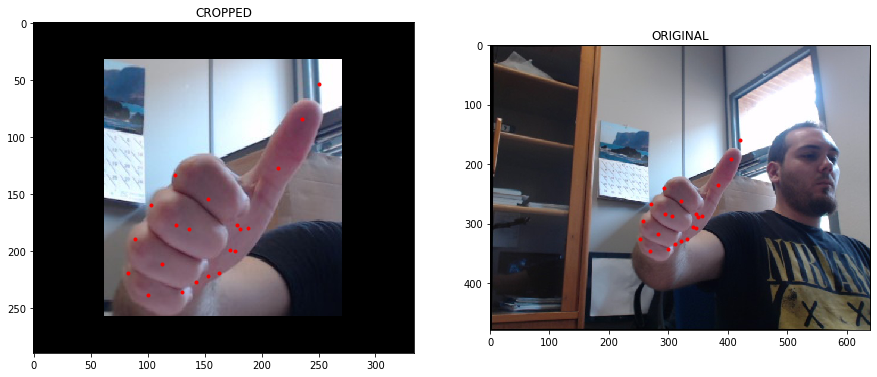

In [17]:
#The labels on the image were visualized to check. 
#Each joint coordinate was visualized as a red dot on the hand image.

import random

image_name=random.choice(list(joints_scaled.keys()))

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,15))
ax1.imshow(padded_images[image_name])
for k,v in joints_scaled[image_name]:
    ax1.plot(k,v, '.', color="red")
ax1.set_title("CROPPED")


ax2.imshow(dataset["images"][image_name])
for k,v in dataset["joints"][image_name]:
    ax2.plot(k,v, '.', color="red")
ax2.set_title("ORIGINAL")

In [18]:
def create_pickle_cropped_and_scaled():
    """
    Create a pickled from dictionary for cropped and scaled joints (data_hand_pose_cropped.pickle)
    """
    my_dict = {"images": padded_images,
              "joints": joints_scaled,
              "bounding": bboxs}
    with open("data_hand_pose.pickle", "wb") as dataset:
        pickle.dump(my_dict, dataset)

In [19]:
create_pickle_cropped_and_scaled()

In [20]:
del cropped_images, max_w, max_h,joints_scaled,bboxs